In [827]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from torch import nn
from torch.utils.data import DataLoader
from torchsummary import summary
from tqdm import tqdm

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_parquet('../data/songs_optimized.parquet')

# Pre-procesado del dataframe

In [828]:
df.head()

,Artist(s),song,text,Length,emotion,Genre,Album,Release Date,Key,Tempo,...,Good for Morning Routine,Similar Artist 1,Similar Song 1,Similarity Score 1,Similar Artist 2,Similar Song 2,Similarity Score 2,Similar Artist 3,Similar Song 3,Similarity Score 3
0,!!!,Even When the Waters Cold,Friends told her she was better off at the bot...,03:47,sadness,hip hop,Thr!!!er,29th April 2013,D min,105,...,False,Corey Smith,If I Could Do It Again,0.986061,Toby Keith,Drinks After Work,0.983719,Space,Neighbourhood,0.983236
1,!!!,One Girl / One Boy,"Well I heard it, playing soft From a drunken b...",04:03,sadness,hip hop,Thr!!!er,29th April 2013,A# min,117,...,False,Hiroyuki Sawano,BRE@TH//LESS,0.995409,When In Rome,Heaven Knows,0.990905,Justice Crew,Everybody,0.984483
2,!!!,Pardon My Freedom,"Oh my god, did I just say that out loud? Shoul...",05:51,joy,hip hop,Louden Up Now,8th June 2004,A Maj,121,...,False,Ricky Dillard,More Abundantly Medley Live,0.993176,Juliet,Avalon,0.965147,The Jacksons,Lovely One,0.956752
3,!!!,Ooo,[Verse 1] Remember when I called you on the te...,03:44,joy,hip hop,As If,16th October 2015,A min,122,...,False,Eric Clapton,Man Overboard,0.992749,Roxette,Don't Believe In Accidents,0.991494,Tiwa Savage,My Darlin,0.990381
4,!!!,Freedom 15,[Verse 1] Calling me like I got something to s...,06:00,joy,hip hop,As If,16th October 2015,F min,123,...,False,Cibo Matto,Lint Of Love,0.981610,Barrington Levy,Better Than Gold,0.981524,Freestyle,Its Automatic,0.981415


In [829]:
df.dtypes

Artist(s)                         category
song                                object
text                                object
Length                              object
emotion                           category
Genre                             category
Album                             category
Release Date                        object
Key                               category
Tempo                                int64
Loudness (db)                       object
Time signature                    category
Explicit                              bool
Popularity                           uint8
Energy                               uint8
Danceability                         uint8
Positiveness                         uint8
Speechiness                          uint8
Liveness                             uint8
Acousticness                         uint8
Instrumentalness                     uint8
Good for Party                        bool
Good for Work/Study                   bool
Good for Re

In [830]:
#guardar nombre de las canciones, para la validación?
nameSongs = df['song']

In [831]:
#columnas a eliminar que no tienen relevancia para predecir la popularidad
columnas_innecesarias = ['Artist(s)', 'text', 'Similar Artist 1', 'Similar Song 1', 'Similar Artist 2', 'Similar Song 2',
                         'Similar Artist 3', 'Similar Song 3', 'Similarity Score 1', 'Similarity Score 2', 'Similarity Score 3',
                         'song', 'Album']

#eliminar release date??

In [832]:
#eliminar columnas
df.drop(columns = columnas_innecesarias, inplace = True)

In [833]:
df.dtypes

Length                              object
emotion                           category
Genre                             category
Release Date                        object
Key                               category
Tempo                                int64
Loudness (db)                       object
Time signature                    category
Explicit                              bool
Popularity                           uint8
Energy                               uint8
Danceability                         uint8
Positiveness                         uint8
Speechiness                          uint8
Liveness                             uint8
Acousticness                         uint8
Instrumentalness                     uint8
Good for Party                        bool
Good for Work/Study                   bool
Good for Relaxation/Meditation        bool
Good for Exercise                     bool
Good for Running                      bool
Good for Yoga/Stretching              bool
Good for Dr

In [834]:
#ver si faltan datos
df.isnull().sum()

Length                            0
emotion                           0
Genre                             0
Release Date                      0
Key                               0
Tempo                             0
Loudness (db)                     0
Time signature                    8
Explicit                          0
Popularity                        0
Energy                            0
Danceability                      0
Positiveness                      0
Speechiness                       0
Liveness                          0
Acousticness                      0
Instrumentalness                  0
Good for Party                    0
Good for Work/Study               0
Good for Relaxation/Meditation    0
Good for Exercise                 0
Good for Running                  0
Good for Yoga/Stretching          0
Good for Driving                  0
Good for Social Gatherings        0
Good for Morning Routine          0
dtype: int64

In [835]:
#en las siguientes líneas de código se van a formatear
#todas las columnas para que tengan entradas numéricas

In [836]:
#convertir duración de la canción a segundos
df['Duration_sec'] = df['Length'].str.split(':').apply(lambda x: int(x[0])*60 + int(x[1]))
df.drop(columns=['Length'], inplace=True)  # eliminar la columna original

In [837]:
#convertir Loudness a valor numérico (quitar db y que no sea object)
df['Loudness (db)'] = df['Loudness (db)'].str.replace('db', '', regex=False).str.strip()
df['Loudness (db)'] = pd.to_numeric(df['Loudness (db)'], errors='coerce')

In [838]:
#confirmar si se hizo bien la conversión
print(f"Valores NaN en Loudness (db): {df['Loudness (db)'].isna().sum()}")

Valores NaN en Loudness (db): 0


In [839]:
print(df['Loudness (db)'].head())


0   -6.85
1   -5.75
2   -6.06
3   -5.42
4   -5.57
Name: Loudness (db), dtype: float64


In [840]:
#convertir columnas booleanas a valor 0 y 1
#identificar las columnas
bool_cols = df.select_dtypes(include='bool').columns
#hacer conversión
df[bool_cols] = df[bool_cols].astype(int)

In [841]:
#ver datos
print(df[bool_cols].head())

   Explicit  Good for Party  Good for Work/Study  \
0         0               0                    0   
1         0               0                    0   
2         0               0                    0   
3         0               0                    0   
4         0               0                    0   

   Good for Relaxation/Meditation  Good for Exercise  Good for Running  \
0                               0                  0                 0   
1                               0                  0                 0   
2                               0                  1                 0   
3                               0                  1                 0   
4                               0                  1                 0   

   Good for Yoga/Stretching  Good for Driving  Good for Social Gatherings  \
0                         0                 0                           0   
1                         0                 0                           0   
2          

In [842]:
df.dtypes

emotion                           category
Genre                             category
Release Date                        object
Key                               category
Tempo                                int64
Loudness (db)                      float64
Time signature                    category
Explicit                             int64
Popularity                           uint8
Energy                               uint8
Danceability                         uint8
Positiveness                         uint8
Speechiness                          uint8
Liveness                             uint8
Acousticness                         uint8
Instrumentalness                     uint8
Good for Party                       int64
Good for Work/Study                  int64
Good for Relaxation/Meditation       int64
Good for Exercise                    int64
Good for Running                     int64
Good for Yoga/Stretching             int64
Good for Driving                     int64
Good for So

In [843]:
#ver cantidad de valores distintos
df['emotion'].nunique(), df['Genre'].nunique()

(13, 3097)

In [844]:
df['emotion'].value_counts(dropna=False)

emotion
joy          209009
sadness      171078
anger        109678
fear          28097
love          27963
surprise       5592
True             17
Love              3
pink              2
confusion         1
angry             1
interest          1
thirst            1
Name: count, dtype: int64

In [845]:
#convertir amociones a  minúscula y eliminar espacios
df['emotion'] = df['emotion'].astype(str).str.lower().str.strip()

In [846]:
# mapeo de emociones válidas
emotion_map = {
    'sadness': 'sadness',
    'joy': 'joy',
    'love': 'love',
    'surprise': 'surprise',
    'anger': 'anger',
    'angry': 'anger',
    'fear': 'fear'
}
df['emotion'] = df['emotion'].map(emotion_map).fillna('unknown')

#como solo hay 22 canciones con valores inválidos se eliminan
df = df[df['emotion'] != 'unknown']

In [847]:
print(df['emotion'].value_counts())

emotion
joy         209009
sadness     171078
anger       109679
fear         28097
love         27966
surprise      5592
Name: count, dtype: int64


In [848]:
#cantidad de filas con valores NaN apra time signature
num_nan = df['Time signature'].isna().sum()
print(f"Cantidad de filas con NaN en time_signature: {num_nan}")

Cantidad de filas con NaN en time_signature: 8


In [849]:
#liminar filas con valoes NaN como son pocas
df = df.dropna(subset=['Time signature'])

In [850]:
num_nan = df['Time signature'].isna().sum()
print(f"Cantidad de filas con NaN en time_signature: {num_nan}")

Cantidad de filas con NaN en time_signature: 0


In [851]:
num_nan = df['emotion'].isna().sum()
print(f"Cantidad de filas con NaN : {num_nan}")

Cantidad de filas con NaN : 0


In [852]:
#Popularidad promedio por emoción (antes de OneHot)
if 'emotion' in df.columns:                          # por si aún existe la columna original
    pop_by_emo = df.groupby('emotion')['Popularity'].mean().sort_values(ascending=False)
    print("\nPopularidad promedio por emoción:")
    print(pop_by_emo)


Popularidad promedio por emoción:
emotion
love        33.024423
surprise    32.609800
joy         32.442581
anger       32.292007
fear        31.977044
sadness     31.921186
Name: Popularity, dtype: float64


In [853]:
good_for_cols = [
    'Good for Party', 'Good for Work/Study', 'Good for Relaxation/Meditation',
    'Good for Exercise', 'Good for Running', 'Good for Yoga/Stretching',
    'Good for Driving', 'Good for Social Gatherings', 'Good for Morning Routine'
]
# Agrupar por emoción y luego calcular el promedio para cada good_for
resultados = []

for contexto in good_for_cols:
    subset = df[df[contexto] == 1]
    promedio = subset.groupby('emotion')['Popularity'].mean().reset_index()
    promedio['contexto'] = contexto
    resultados.append(promedio)

# Unir datos
df_comb = pd.concat(resultados, ignore_index=True)

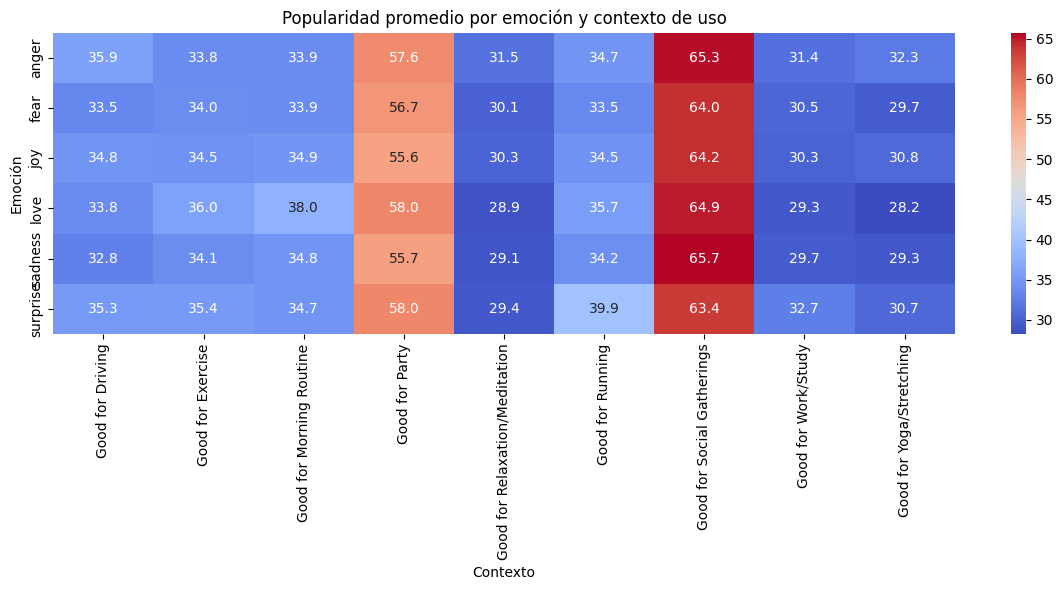

In [854]:
# Pivot para formato de matriz, emociones como fila y contextos como columna)
pivot_table = df_comb.pivot(index='emotion', columns='contexto', values='Popularity')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap='coolwarm')
plt.title("Popularidad promedio por emoción y contexto de uso")
plt.ylabel("Emoción")
plt.xlabel("Contexto")
plt.tight_layout()
plt.show()

In [855]:
num_nan = df['Key'].isna().sum()
print(f"Cantidad de filas con NaN: {num_nan}")

Cantidad de filas con NaN: 0


In [856]:
#hacer one hot encodig para las columnas de tipo category
colTypeCategory = ['emotion', 'Key', 'Time signature']
encoder = OneHotEncoder(sparse_output = False) #retorne un array denso
encoded = encoder.fit_transform(df[colTypeCategory]) #aplicar encoder a las columnas

#convertir el array a un dataframe
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(colTypeCategory))
#eliminar columnas de tipo category
df = df.drop(colTypeCategory, axis=1)
#añadir columnas de encoded_df al df original
df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)


In [857]:
df.dtypes

Genre                             category
Release Date                        object
Tempo                                int64
Loudness (db)                      float64
Explicit                             int64
Popularity                           uint8
Energy                               uint8
Danceability                         uint8
Positiveness                         uint8
Speechiness                          uint8
Liveness                             uint8
Acousticness                         uint8
Instrumentalness                     uint8
Good for Party                       int64
Good for Work/Study                  int64
Good for Relaxation/Meditation       int64
Good for Exercise                    int64
Good for Running                     int64
Good for Yoga/Stretching             int64
Good for Driving                     int64
Good for Social Gatherings           int64
Good for Morning Routine             int64
Duration_sec                         int64
emotion_ang

In [858]:
timeSignature_cols = [col for col in df.columns if col.startswith('Time signature')]
print(timeSignature_cols)

['Time signature_1/4', 'Time signature_3/4', 'Time signature_4/4', 'Time signature_5/4']


In [859]:
key_cols = [col for col in df.columns if col.startswith('Key_')]
print("Categorías de key codificadas:", key_cols)

Categorías de key codificadas: ['Key_A Maj', 'Key_A min', 'Key_A# Maj', 'Key_A# min', 'Key_B Maj', 'Key_B min', 'Key_C Maj', 'Key_C min', 'Key_C# Maj', 'Key_C# min', 'Key_D Maj', 'Key_D min', 'Key_D# Maj', 'Key_D# min', 'Key_E Maj', 'Key_E min', 'Key_F Maj', 'Key_F min', 'Key_F# Maj', 'Key_F# min', 'Key_G Maj', 'Key_G min', 'Key_G# Maj', 'Key_G# min']


In [860]:
emotion_cols = [col for col in df.columns if col.startswith('emotion_')]
print("Categorías de emotion codificadas:", emotion_cols)

Categorías de emotion codificadas: ['emotion_anger', 'emotion_fear', 'emotion_joy', 'emotion_love', 'emotion_sadness', 'emotion_surprise']


In [861]:
#convertir a valores enteros las columnas generadas por one hot encoding
time_signature_columnas = [col for col in df.columns if col.startswith('Time signature_')]
df[time_signature_columnas] = df[time_signature_columnas].astype(int)
emotion_columnas = [col for col in df.columns if col.startswith('emotion_')]
df[emotion_columnas] = df[emotion_columnas].astype(int)
key_columnas = [col for col in df.columns if col.startswith('Key_')]
df[key_columnas] = df[key_columnas].astype(int)

In [862]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551413 entries, 0 to 551412
Data columns (total 57 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   Genre                           551413 non-null  category
 1   Release Date                    551413 non-null  object  
 2   Tempo                           551413 non-null  int64   
 3   Loudness (db)                   551413 non-null  float64 
 4   Explicit                        551413 non-null  int64   
 5   Popularity                      551413 non-null  uint8   
 6   Energy                          551413 non-null  uint8   
 7   Danceability                    551413 non-null  uint8   
 8   Positiveness                    551413 non-null  uint8   
 9   Speechiness                     551413 non-null  uint8   
 10  Liveness                        551413 non-null  uint8   
 11  Acousticness                    551413 non-null  uint8   
 12  In

In [863]:
num_nan = df['Genre'].isna().sum()
print(f"Cantidad de filas con NaN: {num_nan}")

Cantidad de filas con NaN: 0


In [864]:
#con genre no era conveniente hace One Hot coding, porque creaba una columna por cada
#combinación de géneros que tenía una canción, y se quiere una columna por cada género único

#crear lista con los géneros presentes en el dataset
df['listaGeneros'] = df['Genre'].str.split(',')
#apra usar el codificador
mlb = MultiLabelBinarizer()
#asignación de 0 y 1 por cada lista de géneros en Genre por canción
listaGenreBinario = pd.DataFrame(mlb.fit_transform(df['listaGeneros']),
                             columns=[f'Genre_{g.strip()}' for g in mlb.classes_],
                             index=df.index)
#agregar las columnnas por cada género al df
df = pd.concat([df, listaGenreBinario], axis=1)

#sacar las columnas que no se necesitan
df.drop(columns=['Genre', 'listaGeneros'], inplace=True)

In [865]:
df.dtypes

Release Date           object
Tempo                   int64
Loudness (db)         float64
Explicit                int64
Popularity              uint8
                       ...   
Genre_thrash metal      int64
Genre_trance            int64
Genre_trap              int64
Genre_trip-hop          int64
Genre_worship           int64
Length: 144, dtype: object

In [866]:
genre_cols = [col for col in df.columns if col.startswith('Genre_')]
print(genre_cols)

['Genre_acoustic', 'Genre_alt-country', 'Genre_alternative', 'Genre_alternative rock', 'Genre_ambient', 'Genre_black metal', 'Genre_blues', 'Genre_britpop', 'Genre_chillout', 'Genre_chillwave', 'Genre_christian', 'Genre_classic rock', 'Genre_classical', 'Genre_cloud rap', 'Genre_comedy', 'Genre_country', 'Genre_dance', 'Genre_dancehall', 'Genre_death metal', 'Genre_deathcore', 'Genre_disco', 'Genre_doom metal', 'Genre_dream pop', 'Genre_drum and bass', 'Genre_dub', 'Genre_dubstep', 'Genre_electro', 'Genre_electronic', 'Genre_electropop', 'Genre_emo', 'Genre_emo rap', 'Genre_experimental', 'Genre_folk', 'Genre_funk', 'Genre_garage rock', 'Genre_gospel', 'Genre_grime', 'Genre_grunge', 'Genre_hard rock', 'Genre_hardcore', 'Genre_heavy metal', 'Genre_hip hop', 'Genre_hip-hop', 'Genre_house', 'Genre_indie', 'Genre_indie pop', 'Genre_indie rock', 'Genre_industrial', 'Genre_j-pop', 'Genre_jazz', 'Genre_k-pop', 'Genre_latin', 'Genre_lo-fi', 'Genre_math rock', 'Genre_melodic death metal', 'Genr

In [867]:
#unir en una sola columna la columna Genre_hip hop y Genre_hip-hop 
df['Genre_hip-hop'] = df['Genre_hip hop'] | df['Genre_hip-hop']
df['Genre_hip-hop'] = df['Genre_hip-hop'].astype(int)

# eliminar columna Genre_hip hop
df = df.drop(columns=['Genre_hip hop'])

In [868]:
genre_cols = [col for col in df.columns if col.startswith('Genre_')]  # todas las columnas de género
genre_counts = df[genre_cols].sum().sort_values(ascending=False)  # suma cuántas veces aparece cada género
print(genre_counts)

Genre_hip-hop             293652
Genre_rock                 84108
Genre_pop                  64385
Genre_alternative rock     40271
Genre_indie rock           22743
                           ...  
Genre_alt-country            602
Genre_worship                450
Genre_psychedelic            323
Genre_chillout               149
Genre_reggaeton               34
Length: 87, dtype: int64


In [869]:
print(df.columns.tolist())
print(df.info())

['Release Date', 'Tempo', 'Loudness (db)', 'Explicit', 'Popularity', 'Energy', 'Danceability', 'Positiveness', 'Speechiness', 'Liveness', 'Acousticness', 'Instrumentalness', 'Good for Party', 'Good for Work/Study', 'Good for Relaxation/Meditation', 'Good for Exercise', 'Good for Running', 'Good for Yoga/Stretching', 'Good for Driving', 'Good for Social Gatherings', 'Good for Morning Routine', 'Duration_sec', 'emotion_anger', 'emotion_fear', 'emotion_joy', 'emotion_love', 'emotion_sadness', 'emotion_surprise', 'Key_A Maj', 'Key_A min', 'Key_A# Maj', 'Key_A# min', 'Key_B Maj', 'Key_B min', 'Key_C Maj', 'Key_C min', 'Key_C# Maj', 'Key_C# min', 'Key_D Maj', 'Key_D min', 'Key_D# Maj', 'Key_D# min', 'Key_E Maj', 'Key_E min', 'Key_F Maj', 'Key_F min', 'Key_F# Maj', 'Key_F# min', 'Key_G Maj', 'Key_G min', 'Key_G# Maj', 'Key_G# min', 'Time signature_1/4', 'Time signature_3/4', 'Time signature_4/4', 'Time signature_5/4', 'Genre_acoustic', 'Genre_alt-country', 'Genre_alternative', 'Genre_alternat

In [870]:
df.drop(columns=['Release Date'], inplace=True)


In [871]:
df

,Tempo,Loudness (db),Explicit,Popularity,Energy,Danceability,Positiveness,Speechiness,Liveness,Acousticness,...,Genre_soul,Genre_soundtrack,Genre_swing,Genre_synthpop,Genre_techno,Genre_thrash metal,Genre_trance,Genre_trap,Genre_trip-hop,Genre_worship
0,105,-6.85,0,40,83,71,87,4,16,11,...,0,0,0,0,0,0,0,0,0,0
1,117,-5.75,0,42,85,70,87,4,32,0,...,0,0,0,0,0,0,0,0,0,0
2,121,-6.06,0,29,89,71,63,8,64,0,...,0,0,0,0,0,0,0,0,0,0
3,122,-5.42,0,24,84,78,97,4,12,12,...,0,0,0,0,0,0,0,0,0,0
4,123,-5.57,0,30,71,77,70,7,10,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551408,140,-10.00,1,31,82,83,19,16,9,39,...,0,0,0,0,0,0,0,0,0,0
551409,128,-9.68,0,29,43,39,26,3,10,54,...,0,0,0,0,0,0,0,0,0,0
551410,75,-4.67,0,21,79,56,41,5,19,0,...,0,0,0,0,0,0,0,0,0,0
551411,126,-3.93,0,5,90,59,69,4,7,27,...,0,0,0,0,0,0,0,0,0,0


# Análisis exploratorio

In [872]:
#Hacer análisis exploratorio
df.corr()

,Tempo,Loudness (db),Explicit,Popularity,Energy,Danceability,Positiveness,Speechiness,Liveness,Acousticness,...,Genre_soul,Genre_soundtrack,Genre_swing,Genre_synthpop,Genre_techno,Genre_thrash metal,Genre_trance,Genre_trap,Genre_trip-hop,Genre_worship
Tempo,1.000000,0.127042,-0.012298,0.009248,0.178303,-0.111893,0.027774,0.009046,0.011176,-0.150223,...,-0.024750,0.000273,-0.011896,0.005868,0.008442,0.016559,0.004035,0.031802,0.001681,0.007503
Loudness (db),0.127042,1.000000,0.145099,0.088323,0.746677,0.112151,0.173336,0.060385,0.084055,-0.543750,...,-0.037585,-0.025624,-0.046705,-0.000314,0.004478,0.028797,-0.007929,0.030360,-0.006240,0.009916
Explicit,-0.012298,0.145099,1.000000,0.004827,0.095770,0.324089,0.028230,0.494201,0.031349,-0.161329,...,-0.075702,-0.011215,-0.015167,-0.056466,-0.019528,-0.005829,-0.011793,0.220525,-0.016094,-0.018298
Popularity,0.009248,0.088323,0.004827,1.000000,0.046767,0.107893,0.080540,-0.080392,-0.055607,-0.061171,...,0.028496,-0.017046,0.005966,0.030037,0.005017,0.003265,-0.010077,0.086715,0.017166,-0.009460
Energy,0.178303,0.746677,0.095770,0.046767,1.000000,-0.007537,0.258183,0.108398,0.177924,-0.672723,...,-0.063814,-0.021942,-0.065455,0.020060,0.010893,0.086155,0.005672,-0.006106,-0.000005,0.011001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Genre_thrash metal,0.016559,0.028797,-0.005829,0.003265,0.086155,-0.087435,-0.044834,0.001074,0.003441,-0.056699,...,-0.012537,-0.005813,-0.005654,-0.009471,-0.002888,1.000000,-0.004849,-0.012284,-0.002513,-0.002076
Genre_trance,0.004035,-0.007929,-0.011793,-0.010077,0.005672,0.007737,-0.000809,-0.008612,0.002200,-0.004392,...,-0.011519,-0.005341,-0.005195,0.017270,0.028975,-0.004849,1.000000,-0.011286,0.010329,-0.001908
Genre_trap,0.031802,0.030360,0.220525,0.086715,-0.006106,0.115528,-0.029063,0.121741,-0.006244,-0.041963,...,-0.024176,-0.013529,-0.013159,-0.022043,-0.006721,-0.012284,-0.011286,1.000000,-0.005849,-0.004832
Genre_trip-hop,0.001681,-0.006240,-0.016094,0.017166,-0.000005,-0.000609,-0.006924,-0.011111,0.001478,-0.004143,...,-0.002837,0.026941,-0.002692,-0.004510,-0.001375,-0.002513,0.010329,-0.005849,1.000000,-0.000989


In [873]:
df.corr()['Popularity'].sort_values(ascending=False)

Popularity                    1.000000
Good for Party                0.342266
Good for Social Gatherings    0.201443
Genre_pop                     0.108395
Danceability                  0.107893
                                ...   
Time signature_3/4           -0.044810
Genre_hip-hop                -0.046509
Liveness                     -0.055607
Acousticness                 -0.061171
Speechiness                  -0.080392
Name: Popularity, Length: 142, dtype: float64

In [874]:
df.corr()['Popularity'].sort_values(ascending=False).to_csv('correlaciones_popularity.csv')

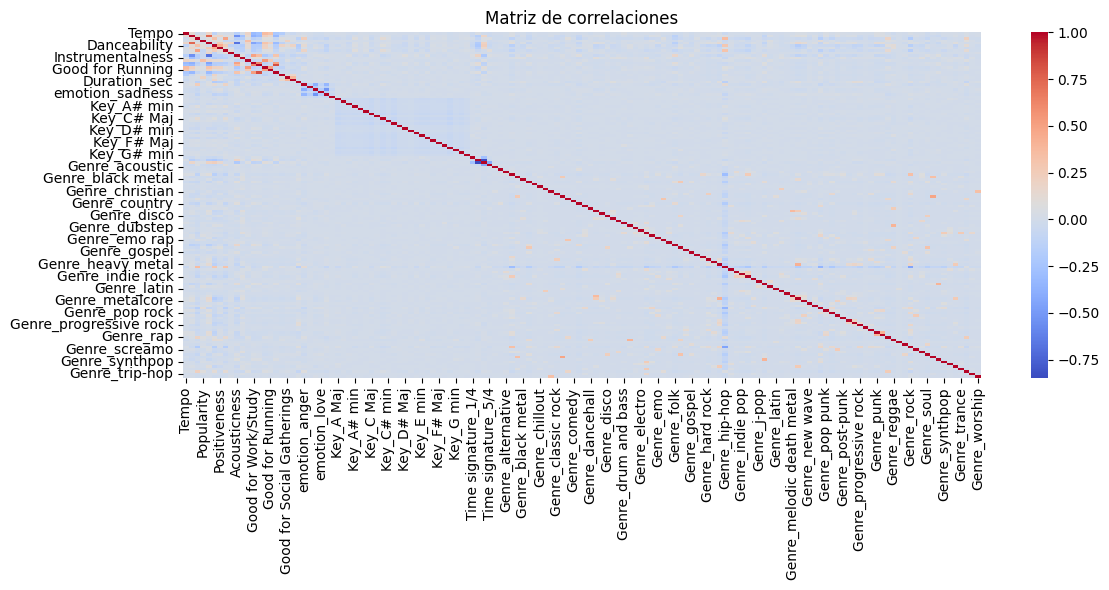

In [875]:
# 1) Matriz de correlaciones numéricas
plt.figure(figsize=(12, 6))
corr = df.corr(numeric_only=True)          # solo columnas numéricas
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Matriz de correlaciones")
plt.tight_layout()
plt.show()

In [876]:
#calcular la popularidad promedio por cada columna good_for_*
good_for_cols = [c for c in df.columns if c.startswith('Good for')]
for col in good_for_cols:
    mean_pop = df.loc[df[col] == 1, 'Popularity'].mean()
    print(f"Popularidad promedio cuando {col}=1  →  {mean_pop:.2f}")

Popularidad promedio cuando Good for Party=1  →  56.31
Popularidad promedio cuando Good for Work/Study=1  →  30.16
Popularidad promedio cuando Good for Relaxation/Meditation=1  →  29.87
Popularidad promedio cuando Good for Exercise=1  →  34.27
Popularidad promedio cuando Good for Running=1  →  34.53
Popularidad promedio cuando Good for Yoga/Stretching=1  →  30.16
Popularidad promedio cuando Good for Driving=1  →  34.41
Popularidad promedio cuando Good for Social Gatherings=1  →  64.87
Popularidad promedio cuando Good for Morning Routine=1  →  34.84


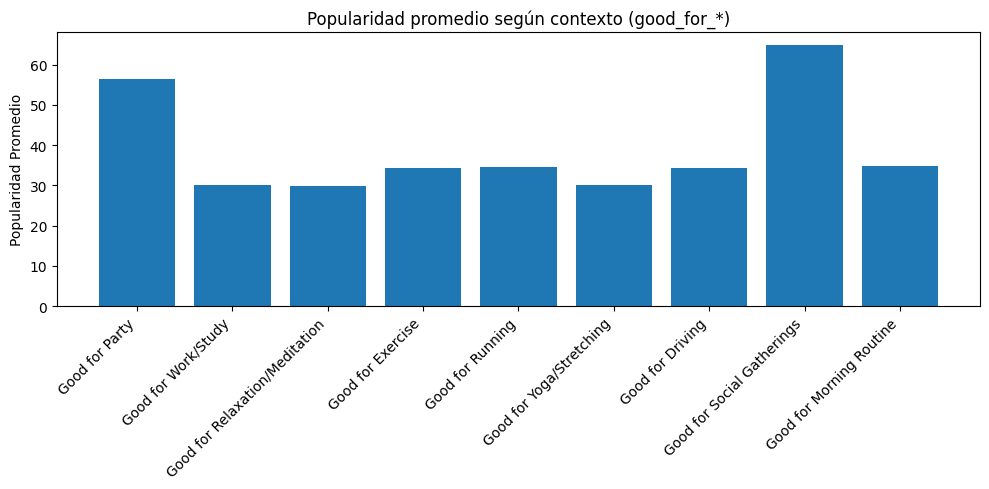

In [877]:
context_columns = [
    'Good for Party', 'Good for Work/Study', 'Good for Relaxation/Meditation',
    'Good for Exercise', 'Good for Running', 'Good for Yoga/Stretching',
    'Good for Driving', 'Good for Social Gatherings', 'Good for Morning Routine'
]

promedios = {
    col: df[df[col] == 1]['Popularity'].mean()
    for col in context_columns
}

plt.figure(figsize=(10, 5))
plt.bar(promedios.keys(), promedios.values())
plt.xticks(rotation=45, ha='right')
plt.ylabel("Popularidad Promedio")
plt.title("Popularidad promedio según contexto (good_for_*)")
plt.tight_layout()
plt.show()

# Modelo de Red Neuronal MLP

## División del dataset

In [1178]:
# Dividir el DataFrame en conjuntos de entrenamiento, validación y prueba
# Se usa un 70% para entrenamiento, un 15% para validación y 15% de prueba

train_df, val_df = train_test_split(df, test_size=0.3, random_state=42, shuffle=False)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42, shuffle=False)

# Normalizar la columna 'Popularity' entre 0 y 1
scaler = MinMaxScaler()
train_df['Popularity'] = scaler.fit_transform(train_df[['Popularity']])
val_df['Popularity'] = scaler.transform(val_df[['Popularity']])
test_df['Popularity'] = scaler.transform(test_df[['Popularity']])

In [1179]:
print(f'Train: {train_df.shape},  Val: {val_df.shape},  Test: {test_df.shape}')

Train: (385989, 142),  Val: (82712, 142),  Test: (82712, 142)


## Modelo popularidad general

### Pre-procesado de datos

In [1243]:
# Convertir el DataFrame a tensores de PyTorch
X_train = torch.tensor(train_df.drop(columns=['Popularity']).values, dtype=torch.float32)
X_train = DataLoader(X_train, batch_size=256, shuffle=False)  # Crear DataLoader para el conjunto de entrenamiento
y_train = torch.tensor(train_df['Popularity'].values, dtype=torch.float32).view(-1, 1)  # Asegurarse de que y tenga la forma correcta
y_train = DataLoader(y_train, batch_size=256, shuffle=False)  # Crear DataLoader para las etiquetas de entrenamiento

X_val = torch.tensor(val_df.drop(columns=['Popularity']).values, dtype=torch.float32)
X_val = DataLoader(X_val, batch_size=128, shuffle=False)  # Crear DataLoader para el conjunto de validación
y_val = torch.tensor(val_df['Popularity'].values, dtype=torch.float32).view(-1, 1)
y_val = DataLoader(y_val, batch_size=128, shuffle=False)  # Crear DataLoader para las etiquetas de validación


X_test = torch.tensor(test_df.drop(columns=['Popularity']).values, dtype=torch.float32)
X_test = DataLoader(X_test, batch_size=128, shuffle=False)  # Crear DataLoader para el conjunto de prueba
y_test = torch.tensor(test_df['Popularity'].values, dtype=torch.float32).view(-1, 1)
y_test = DataLoader(y_test, batch_size=128, shuffle=False)  # Crear DataLoader para las etiquetas de prueba


In [1244]:
len(X_train), len(X_val), len(X_test)

(1508, 647, 647)

### Modelo HL 2, LR 0.0005

#### Modelo

In [1245]:
#Modelo de red neuronal
class MLP_P(nn.Module):
    def __init__(self, hidden_size=10, input_size=141, dropout_p=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.h1 = nn.Linear(in_features=input_size,out_features=self.hidden_size)
        self.h2 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.out = nn.Linear(in_features=self.hidden_size,out_features=1)

        self.dropout = nn.Dropout(p=dropout_p)  # Dropout
        self.act = nn.ReLU()
    def forward(self, x):
        l1 = self.h1(x)  #de entrada a capa oculta
        l2 = self.h2(l1)  #de capa oculta a capa oculta
        l2 = self.act(l2)     #activación
        l2 = self.dropout(l2)  # Aplica dropout
        output = self.out(l2)   #salida
        return output

#### Prueba del modelo

In [1246]:
# Crear modelo
model = MLP_P()

# Mover a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Crear entrada simulada 
x = torch.randn(1, 141).to(device)
# Hacer forward pass
with torch.no_grad():
    output = model.forward(x)

print("Output shape:", output.shape)  # Debería ser [1, 1]

summary(model, input_size=(1, 141))

Output shape: torch.Size([1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]           1,420
            Linear-2                [-1, 1, 10]             110
              ReLU-3                [-1, 1, 10]               0
           Dropout-4                [-1, 1, 10]               0
            Linear-5                 [-1, 1, 1]              11
Total params: 1,541
Trainable params: 1,541
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


#### Inicialización del modelo

In [1247]:
#Instanciar el modelo
model = MLP_P(hidden_size=10, input_size=len(df.columns)-1)  # -1 porque la última columna es la de popularidad

# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()  # Mean Squared Error para regresión 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Adam optimizer

#### Entrenamiento del modelo

In [1248]:
#Loop de entrenamiento
epoch = 0
patience= 10
best_epoch = 0
best_model = None

batchs_per_epoch = 45

train_losses = []
val_losses = []
best_val_loss = float('inf')

while True:   
    # Entrenamiento 
    model.train()
    running_loss = 0.0
    for input, labels in tqdm(zip(X_train, y_train), total=len(X_train), desc=f"Epoch {epoch+1}"):
        input, labels = input.to(device), labels.to(device)

        optimizer.zero_grad()

        # Salidas 
        output = model(input)

        # Pérdida combinada
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(X_train))

    # Validación
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for input, labels in zip(X_train, y_train):
            input, labels = input.to(device), labels.to(device)

            # Solo predicción principal en validación
            outputs = model(input)  
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(X_val))
    print(f"Época {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")
    
    # Early stopping
    if best_val_loss > (val_loss / len(X_val)):
        patience = 10
        best_val_loss = val_loss / len(X_val)
        best_epoch = epoch + 1
        best_model = model.state_dict()
        torch.save(best_model, './MejoresPesos/best_model_MLP_P.pth')
        print(f"Nuevo mínimo en loss de validación")   
    else:
        patience -= 1
        if patience <= 0:
            print("Early stopping triggered")
            break
    epoch += 1

Epoch 1: 100%|██████████| 1508/1508 [00:03<00:00, 385.34it/s]


Época 1 | Train Loss: 0.0683 | Val Loss: 0.0792
Nuevo mínimo en loss de validación


Epoch 2: 100%|██████████| 1508/1508 [00:10<00:00, 149.56it/s]


Época 2 | Train Loss: 0.0355 | Val Loss: 0.0769
Nuevo mínimo en loss de validación


Epoch 3: 100%|██████████| 1508/1508 [00:10<00:00, 140.28it/s]


Época 3 | Train Loss: 0.0328 | Val Loss: 0.0776


Epoch 4: 100%|██████████| 1508/1508 [00:10<00:00, 137.59it/s]


Época 4 | Train Loss: 0.0323 | Val Loss: 0.0772


Epoch 5: 100%|██████████| 1508/1508 [00:11<00:00, 136.16it/s]


Época 5 | Train Loss: 0.0324 | Val Loss: 0.0751
Nuevo mínimo en loss de validación


Epoch 6: 100%|██████████| 1508/1508 [00:11<00:00, 129.21it/s]


Época 6 | Train Loss: 0.0318 | Val Loss: 0.0714
Nuevo mínimo en loss de validación


Epoch 7: 100%|██████████| 1508/1508 [00:10<00:00, 139.17it/s]


Época 7 | Train Loss: 0.0311 | Val Loss: 0.0686
Nuevo mínimo en loss de validación


Epoch 8: 100%|██████████| 1508/1508 [00:10<00:00, 138.22it/s]


Época 8 | Train Loss: 0.0303 | Val Loss: 0.0679
Nuevo mínimo en loss de validación


Epoch 9: 100%|██████████| 1508/1508 [00:10<00:00, 142.52it/s]


Época 9 | Train Loss: 0.0300 | Val Loss: 0.0667
Nuevo mínimo en loss de validación


Epoch 10: 100%|██████████| 1508/1508 [00:10<00:00, 150.71it/s]


Época 10 | Train Loss: 0.0299 | Val Loss: 0.0677


Epoch 11: 100%|██████████| 1508/1508 [00:09<00:00, 154.37it/s]


Época 11 | Train Loss: 0.0294 | Val Loss: 0.0656
Nuevo mínimo en loss de validación


Epoch 12: 100%|██████████| 1508/1508 [00:10<00:00, 142.93it/s]


Época 12 | Train Loss: 0.0291 | Val Loss: 0.0649
Nuevo mínimo en loss de validación


Epoch 13: 100%|██████████| 1508/1508 [00:10<00:00, 143.10it/s]


Época 13 | Train Loss: 0.0289 | Val Loss: 0.0644
Nuevo mínimo en loss de validación


Epoch 14: 100%|██████████| 1508/1508 [00:10<00:00, 144.68it/s]


Época 14 | Train Loss: 0.0287 | Val Loss: 0.0643
Nuevo mínimo en loss de validación


Epoch 15: 100%|██████████| 1508/1508 [00:10<00:00, 142.46it/s]


Época 15 | Train Loss: 0.0286 | Val Loss: 0.0637
Nuevo mínimo en loss de validación


Epoch 16: 100%|██████████| 1508/1508 [00:10<00:00, 149.43it/s]


Época 16 | Train Loss: 0.0286 | Val Loss: 0.0643


Epoch 17: 100%|██████████| 1508/1508 [00:09<00:00, 152.22it/s]


Época 17 | Train Loss: 0.0285 | Val Loss: 0.0631
Nuevo mínimo en loss de validación


Epoch 18: 100%|██████████| 1508/1508 [00:10<00:00, 144.53it/s]


Época 18 | Train Loss: 0.0284 | Val Loss: 0.0629
Nuevo mínimo en loss de validación


Epoch 19: 100%|██████████| 1508/1508 [00:10<00:00, 140.22it/s]


Época 19 | Train Loss: 0.0283 | Val Loss: 0.0629


Epoch 20: 100%|██████████| 1508/1508 [00:10<00:00, 144.02it/s]


Época 20 | Train Loss: 0.0282 | Val Loss: 0.0638


Epoch 21: 100%|██████████| 1508/1508 [00:10<00:00, 143.45it/s]


Época 21 | Train Loss: 0.0281 | Val Loss: 0.0622
Nuevo mínimo en loss de validación


Epoch 22: 100%|██████████| 1508/1508 [00:10<00:00, 140.69it/s]


Época 22 | Train Loss: 0.0279 | Val Loss: 0.0621
Nuevo mínimo en loss de validación


Epoch 23: 100%|██████████| 1508/1508 [00:10<00:00, 146.05it/s]


Época 23 | Train Loss: 0.0280 | Val Loss: 0.0621


Epoch 24: 100%|██████████| 1508/1508 [00:10<00:00, 143.36it/s]


Época 24 | Train Loss: 0.0279 | Val Loss: 0.0624


Epoch 25: 100%|██████████| 1508/1508 [00:10<00:00, 148.08it/s]


Época 25 | Train Loss: 0.0278 | Val Loss: 0.0625


Epoch 26: 100%|██████████| 1508/1508 [00:10<00:00, 146.34it/s]


Época 26 | Train Loss: 0.0278 | Val Loss: 0.0626


Epoch 27: 100%|██████████| 1508/1508 [00:10<00:00, 150.31it/s]


Época 27 | Train Loss: 0.0277 | Val Loss: 0.0622


Epoch 28: 100%|██████████| 1508/1508 [00:10<00:00, 137.39it/s]


Época 28 | Train Loss: 0.0277 | Val Loss: 0.0626


Epoch 29: 100%|██████████| 1508/1508 [00:10<00:00, 140.93it/s]


Época 29 | Train Loss: 0.0277 | Val Loss: 0.0624


Epoch 30: 100%|██████████| 1508/1508 [00:10<00:00, 146.29it/s]


Época 30 | Train Loss: 0.0276 | Val Loss: 0.0623


Epoch 31: 100%|██████████| 1508/1508 [00:10<00:00, 144.17it/s]


Época 31 | Train Loss: 0.0277 | Val Loss: 0.0625


Epoch 32: 100%|██████████| 1508/1508 [00:10<00:00, 142.79it/s]


Época 32 | Train Loss: 0.0276 | Val Loss: 0.0625
Early stopping triggered


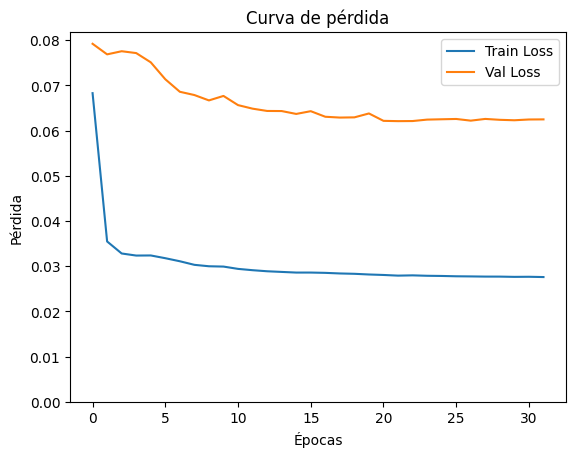

In [1249]:
# Grafica de las curvas de pérdida
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Curva de pérdida')
plt.ylim(0)
plt.show()

#### Testeo del modelo

In [1250]:
# Evaluación del modelo en el conjunto de test
model.eval()
model.load_state_dict(torch.load('./MejoresPesos/best_model_MLP_P.pth'))  # Cargar los mejores pesos del modelo

test_loss = 0.0

preds = []
true = []
with torch.no_grad():
    for input, labels in zip(X_train, y_train):
        input, labels = input.to(device), labels.to(device)

        outputs = model(input)  
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds.append(outputs.cpu().numpy())
        true.append(labels.cpu().numpy())
    
test_loss /= len(X_test)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.0621


In [1251]:
# Metricas de evaluación
y_pred = np.concatenate(preds).reshape(-1, 1).ravel()
y_true = np.concatenate(true).reshape(-1, 1).ravel()

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 0.13
RMSE: 0.16
R²: 0.20


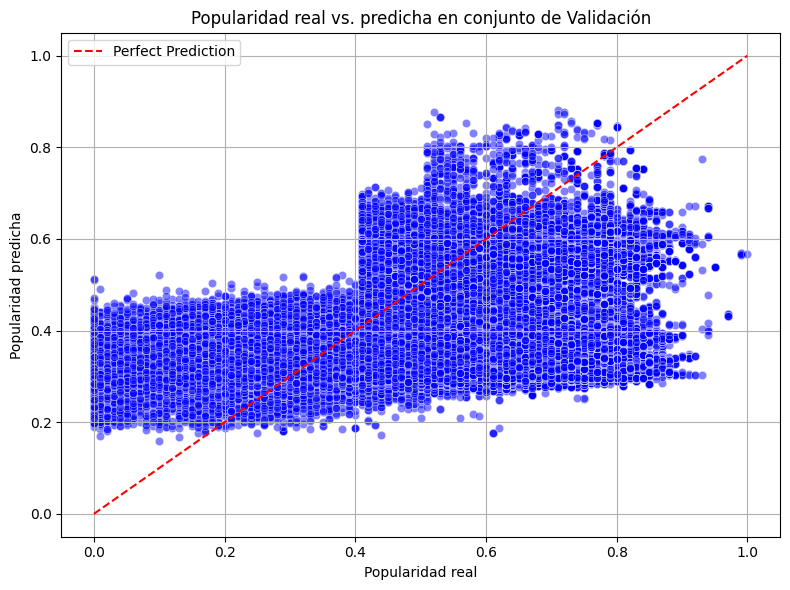

In [1252]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.5, color="blue")

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel("Popularidad real")
plt.ylabel("Popularidad predicha")
plt.title("Popularidad real vs. predicha en conjunto de Validación")
plt.legend()    
plt.grid(True)
plt.tight_layout()
plt.show()

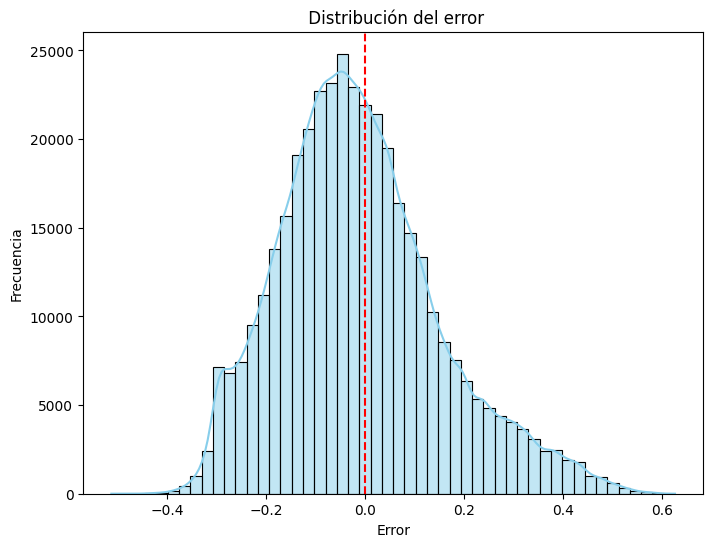

In [1253]:
residuos = y_true - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuos, bins=50, kde=True, color="skyblue")
plt.title(" Distribución del error")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.axvline(0, color='red', linestyle='--')
plt.show()

### Modelo HL 5, LR 0.0005

#### Modelo

In [1254]:
#Modelo de red neuronal
class MLP_P3(nn.Module):
    def __init__(self, hidden_size=10, input_size=141, dropout_p=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.h1 = nn.Linear(in_features=input_size,out_features=self.hidden_size)
        self.h2 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.h3 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.h4 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.h5 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.out = nn.Linear(in_features=self.hidden_size,out_features=1)
        
        self.dropout = nn.Dropout(p=dropout_p)  # Dropout
        self.act = nn.ReLU()
    def forward(self, x):
        l1 = self.h1(x)  #de entrada a capa oculta
        l2 = self.h2(l1)  #de capa oculta a capa oculta
        l3 = self.h2(l2)  #de capa oculta a capa oculta
        l4 = self.h2(l3)  #de capa oculta a capa oculta
        l5 = self.h2(l4)  #de capa oculta a capa oculta
        l5 = self.act(l5)     #activación
        l5 = self.dropout(l5)  # Aplica dropout
        output = self.out(l5)   #salida
        return output

#### Prueba del modelo

In [1255]:
# Crear modelo
model = MLP_P3()

# Mover a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Crear entrada simulada 
x = torch.randn(1, 141).to(device)
# Hacer forward pass
with torch.no_grad():
    output = model.forward(x)

print("Output shape:", output.shape)  # Debería ser [1, 1]

summary(model, input_size=(1, 141))

Output shape: torch.Size([1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]           1,420
            Linear-2                [-1, 1, 10]             110
            Linear-3                [-1, 1, 10]             110
            Linear-4                [-1, 1, 10]             110
            Linear-5                [-1, 1, 10]             110
              ReLU-6                [-1, 1, 10]               0
           Dropout-7                [-1, 1, 10]               0
            Linear-8                 [-1, 1, 1]              11
Total params: 1,871
Trainable params: 1,871
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


#### Inicialización del modelo

In [1256]:
# Instanciar el modelo
model = MLP_P3(hidden_size=10, input_size=len(df.columns)-1)  # -1 porque la última columna es la de popularidad

# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()  # Mean Squared Error para regresión 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Adam optimizer


#### Entrenamiento del modelo

In [1257]:
#Loop de entrenamiento
epoch = 0
patience=10
best_epoch = 0
best_model = None

batchs_per_epoch = 45

train_losses = []
val_losses = []
best_val_loss = float('inf')

while True:
    # Entrenamiento    
    model.train()
    running_loss = 0.0
    for input, labels in tqdm(zip(X_train, y_train), total=len(X_train), desc=f"Epoch {epoch+1}"):
        input, labels = input.to(device), labels.to(device)

        optimizer.zero_grad()

        # Salidas 
        output = model(input)

        # Pérdida combinada
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(X_train))

    # Validación
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for input, labels in zip(X_train, y_train):
            input, labels = input.to(device), labels.to(device)

            # Solo predicción principal en validación
            outputs = model(input)  
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(X_val))
    print(f"Época {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")
    
    # Early stopping
    if best_val_loss > (val_loss / len(X_val)):
        patience = 10
        best_val_loss = val_loss / len(X_val)
        best_epoch = epoch + 1
        best_model = model.state_dict()
        torch.save(best_model, './MejoresPesos/best_model_MLP_P3.pth')
        print(f"Nuevo mínimo en loss de validación")   
    else:
        patience -= 1
        if patience <= 0:
            print("Early stopping triggered")
            break
    epoch += 1

Epoch 1: 100%|██████████| 1508/1508 [00:11<00:00, 133.42it/s]


Época 1 | Train Loss: 0.0461 | Val Loss: 0.0752
Nuevo mínimo en loss de validación


Epoch 2: 100%|██████████| 1508/1508 [00:12<00:00, 121.25it/s]


Época 2 | Train Loss: 0.0335 | Val Loss: 0.0763


Epoch 3: 100%|██████████| 1508/1508 [00:11<00:00, 131.65it/s]


Época 3 | Train Loss: 0.0325 | Val Loss: 0.0766


Epoch 4: 100%|██████████| 1508/1508 [00:11<00:00, 134.76it/s]


Época 4 | Train Loss: 0.0321 | Val Loss: 0.0744
Nuevo mínimo en loss de validación


Epoch 5: 100%|██████████| 1508/1508 [00:11<00:00, 132.40it/s]


Época 5 | Train Loss: 0.0316 | Val Loss: 0.0730
Nuevo mínimo en loss de validación


Epoch 6: 100%|██████████| 1508/1508 [00:03<00:00, 397.47it/s]


Época 6 | Train Loss: 0.0309 | Val Loss: 0.0699
Nuevo mínimo en loss de validación


Epoch 7: 100%|██████████| 1508/1508 [00:03<00:00, 432.05it/s]


Época 7 | Train Loss: 0.0302 | Val Loss: 0.0687
Nuevo mínimo en loss de validación


Epoch 8: 100%|██████████| 1508/1508 [00:03<00:00, 420.64it/s]


Época 8 | Train Loss: 0.0296 | Val Loss: 0.0665
Nuevo mínimo en loss de validación


Epoch 9: 100%|██████████| 1508/1508 [00:03<00:00, 446.23it/s]


Época 9 | Train Loss: 0.0293 | Val Loss: 0.0658
Nuevo mínimo en loss de validación


Epoch 10: 100%|██████████| 1508/1508 [00:03<00:00, 430.60it/s]


Época 10 | Train Loss: 0.0289 | Val Loss: 0.0654
Nuevo mínimo en loss de validación


Epoch 11: 100%|██████████| 1508/1508 [00:03<00:00, 440.69it/s]


Época 11 | Train Loss: 0.0288 | Val Loss: 0.0648
Nuevo mínimo en loss de validación


Epoch 12: 100%|██████████| 1508/1508 [00:03<00:00, 435.94it/s]


Época 12 | Train Loss: 0.0287 | Val Loss: 0.0646
Nuevo mínimo en loss de validación


Epoch 13: 100%|██████████| 1508/1508 [00:03<00:00, 416.31it/s]


Época 13 | Train Loss: 0.0285 | Val Loss: 0.0644
Nuevo mínimo en loss de validación


Epoch 14: 100%|██████████| 1508/1508 [00:03<00:00, 429.84it/s]


Época 14 | Train Loss: 0.0284 | Val Loss: 0.0642
Nuevo mínimo en loss de validación


Epoch 15: 100%|██████████| 1508/1508 [00:03<00:00, 483.01it/s]


Época 15 | Train Loss: 0.0283 | Val Loss: 0.0640
Nuevo mínimo en loss de validación


Epoch 16: 100%|██████████| 1508/1508 [00:03<00:00, 389.56it/s]


Época 16 | Train Loss: 0.0283 | Val Loss: 0.0635
Nuevo mínimo en loss de validación


Epoch 17: 100%|██████████| 1508/1508 [00:03<00:00, 439.03it/s]


Época 17 | Train Loss: 0.0282 | Val Loss: 0.0637


Epoch 18: 100%|██████████| 1508/1508 [00:09<00:00, 155.68it/s]


Época 18 | Train Loss: 0.0282 | Val Loss: 0.0635


Epoch 19: 100%|██████████| 1508/1508 [00:14<00:00, 104.71it/s]


Época 19 | Train Loss: 0.0281 | Val Loss: 0.0638


Epoch 20: 100%|██████████| 1508/1508 [00:15<00:00, 96.10it/s] 


Época 20 | Train Loss: 0.0281 | Val Loss: 0.0638


Epoch 21: 100%|██████████| 1508/1508 [00:16<00:00, 92.67it/s] 


Época 21 | Train Loss: 0.0281 | Val Loss: 0.0636


Epoch 22: 100%|██████████| 1508/1508 [00:14<00:00, 100.65it/s]


Época 22 | Train Loss: 0.0281 | Val Loss: 0.0632
Nuevo mínimo en loss de validación


Epoch 23: 100%|██████████| 1508/1508 [00:14<00:00, 101.10it/s]


Época 23 | Train Loss: 0.0281 | Val Loss: 0.0636


Epoch 24: 100%|██████████| 1508/1508 [00:15<00:00, 97.78it/s] 


Época 24 | Train Loss: 0.0281 | Val Loss: 0.0638


Epoch 25: 100%|██████████| 1508/1508 [00:16<00:00, 92.86it/s] 


Época 25 | Train Loss: 0.0281 | Val Loss: 0.0635


Epoch 26: 100%|██████████| 1508/1508 [00:14<00:00, 103.46it/s]


Época 26 | Train Loss: 0.0280 | Val Loss: 0.0636


Epoch 27: 100%|██████████| 1508/1508 [00:14<00:00, 104.84it/s]


Época 27 | Train Loss: 0.0280 | Val Loss: 0.0634


Epoch 28: 100%|██████████| 1508/1508 [00:14<00:00, 101.39it/s]


Época 28 | Train Loss: 0.0280 | Val Loss: 0.0636


Epoch 29: 100%|██████████| 1508/1508 [00:14<00:00, 105.36it/s]


Época 29 | Train Loss: 0.0280 | Val Loss: 0.0631
Nuevo mínimo en loss de validación


Epoch 30: 100%|██████████| 1508/1508 [00:15<00:00, 95.51it/s] 


Época 30 | Train Loss: 0.0279 | Val Loss: 0.0633


Epoch 31: 100%|██████████| 1508/1508 [00:15<00:00, 96.35it/s] 


Época 31 | Train Loss: 0.0279 | Val Loss: 0.0632


Epoch 32: 100%|██████████| 1508/1508 [00:15<00:00, 97.49it/s] 


Época 32 | Train Loss: 0.0279 | Val Loss: 0.0631


Epoch 33: 100%|██████████| 1508/1508 [00:14<00:00, 101.65it/s]


Época 33 | Train Loss: 0.0279 | Val Loss: 0.0632


Epoch 34: 100%|██████████| 1508/1508 [00:15<00:00, 95.13it/s] 


Época 34 | Train Loss: 0.0279 | Val Loss: 0.0630
Nuevo mínimo en loss de validación


Epoch 35: 100%|██████████| 1508/1508 [00:15<00:00, 96.79it/s] 


Época 35 | Train Loss: 0.0279 | Val Loss: 0.0629
Nuevo mínimo en loss de validación


Epoch 36: 100%|██████████| 1508/1508 [00:15<00:00, 97.65it/s] 


Época 36 | Train Loss: 0.0280 | Val Loss: 0.0628
Nuevo mínimo en loss de validación


Epoch 37: 100%|██████████| 1508/1508 [00:16<00:00, 91.00it/s] 


Época 37 | Train Loss: 0.0279 | Val Loss: 0.0632


Epoch 38: 100%|██████████| 1508/1508 [00:14<00:00, 104.80it/s]


Época 38 | Train Loss: 0.0279 | Val Loss: 0.0631


Epoch 39: 100%|██████████| 1508/1508 [00:15<00:00, 98.46it/s] 


Época 39 | Train Loss: 0.0279 | Val Loss: 0.0630


Epoch 40: 100%|██████████| 1508/1508 [00:16<00:00, 92.33it/s] 


Época 40 | Train Loss: 0.0279 | Val Loss: 0.0631


Epoch 41: 100%|██████████| 1508/1508 [00:13<00:00, 108.91it/s]


Época 41 | Train Loss: 0.0279 | Val Loss: 0.0635


Epoch 42: 100%|██████████| 1508/1508 [00:15<00:00, 95.69it/s] 


Época 42 | Train Loss: 0.0278 | Val Loss: 0.0631


Epoch 43: 100%|██████████| 1508/1508 [00:16<00:00, 93.59it/s] 


Época 43 | Train Loss: 0.0278 | Val Loss: 0.0634


Epoch 44: 100%|██████████| 1508/1508 [00:15<00:00, 95.47it/s] 


Época 44 | Train Loss: 0.0278 | Val Loss: 0.0632


Epoch 45: 100%|██████████| 1508/1508 [00:16<00:00, 89.69it/s] 


Época 45 | Train Loss: 0.0278 | Val Loss: 0.0633


Epoch 46: 100%|██████████| 1508/1508 [00:16<00:00, 92.72it/s] 


Época 46 | Train Loss: 0.0278 | Val Loss: 0.0634
Early stopping triggered


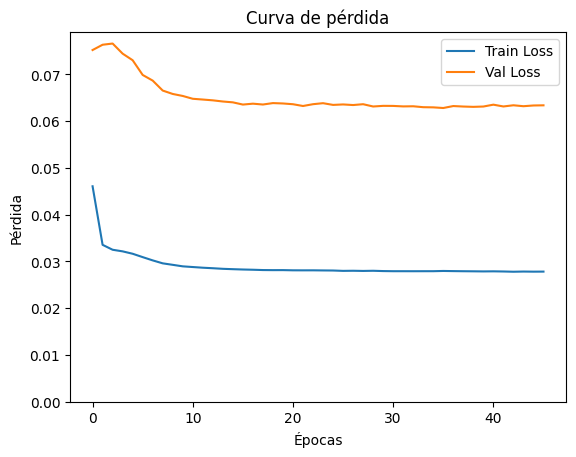

In [1258]:
# Grafica de las curvas de pérdida
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Curva de pérdida')
plt.ylim(0)
plt.show()

#### Testeo del modelo

In [1259]:
# Evaluación del modelo en el conjunto de test
model.eval()
model.load_state_dict(torch.load('./MejoresPesos/best_model_MLP_P3.pth'))  # Cargar los mejores pesos del modelo

test_loss = 0.0

preds = []
true = []
with torch.no_grad():
    for input, labels in zip(X_train, y_train):
        input, labels = input.to(device), labels.to(device)

        outputs = model(input)  
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds.append(outputs.cpu().numpy())
        true.append(labels.cpu().numpy())
    
test_loss /= len(X_test)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0628


In [1260]:
# Metricas de evaluación
y_pred = np.concatenate(preds).reshape(-1, 1).ravel()
y_true = np.concatenate(true).reshape(-1, 1).ravel()

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 0.13
RMSE: 0.16
R²: 0.19


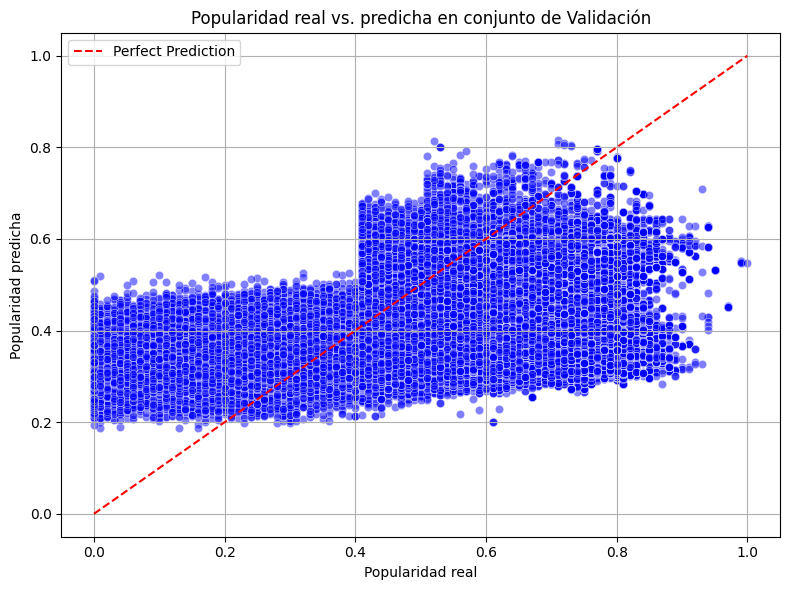

In [1261]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.5, color="blue")

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel("Popularidad real")
plt.ylabel("Popularidad predicha")
plt.title("Popularidad real vs. predicha en conjunto de Validación")
plt.legend()    
plt.grid(True)
plt.tight_layout()
plt.show()

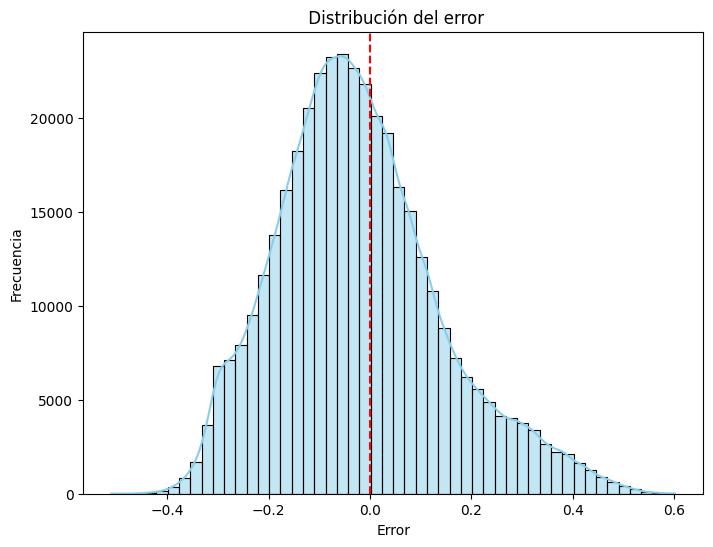

In [1262]:
residuos = y_true - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuos, bins=50, kde=True, color="skyblue")
plt.title(" Distribución del error")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.axvline(0, color='red', linestyle='--')
plt.show()

### Modelo HL 9, LR 0.0001

#### Model

In [1263]:
#Modelo de red neuronal
class MLP_P4(nn.Module):
    def __init__(self, hidden_size=10, input_size=141, dropout_p=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.h1 = nn.Linear(in_features=input_size,out_features=self.hidden_size)
        self.h2 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.h3 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.h4 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.h5 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.h6 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.h7 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.h8 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.h9 = nn.Linear(in_features=self.hidden_size,out_features=self.hidden_size)
        self.out = nn.Linear(in_features=self.hidden_size,out_features=1)

        self.dropout = nn.Dropout(p=dropout_p)
        self.act = nn.ReLU()
    def forward(self, x):
        l1 = self.h1(x)  #de entrada a capa oculta
        l2 = self.h2(l1)  #de capa oculta a capa oculta
        l3 = self.h2(l2)  #de capa oculta a capa oculta
        l4 = self.h2(l3)  #de capa oculta a capa oculta
        l5 = self.h2(l4)  #de capa oculta a capa oculta
        l6 = self.h2(l5)  #de capa oculta a capa oculta
        l7 = self.h2(l6)  #de capa oculta a capa oculta
        l8 = self.h2(l7)  #de capa oculta a capa oculta
        l9 = self.h2(l8)  #de capa oculta a capa oculta
        l9 = self.act(l9)     #activación
        l9 = self.dropout(l9)  # Aplica dropout
        output = self.out(l9)   #salida
        return output

#### Prueba del modelo

In [1264]:
# Crear modelo
model = MLP_P4()

# Mover a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Crear entrada simulada 
x = torch.randn(1, 141).to(device)
# Hacer forward pass
with torch.no_grad():
    output = model.forward(x)

print("Output shape:", output.shape)  # Debería ser [1, 1]

summary(model, input_size=(1, 141))

Output shape: torch.Size([1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]           1,420
            Linear-2                [-1, 1, 10]             110
            Linear-3                [-1, 1, 10]             110
            Linear-4                [-1, 1, 10]             110
            Linear-5                [-1, 1, 10]             110
            Linear-6                [-1, 1, 10]             110
            Linear-7                [-1, 1, 10]             110
            Linear-8                [-1, 1, 10]             110
            Linear-9                [-1, 1, 10]             110
             ReLU-10                [-1, 1, 10]               0
          Dropout-11                [-1, 1, 10]               0
           Linear-12                 [-1, 1, 1]              11
Total params: 2,311
Trainable params: 2,311
Non-trainable params: 0
--

#### Inicialización del modelo

In [1265]:
# Instanciar el modelo
model = MLP_P4(hidden_size=10, input_size=len(df.columns)-1)  # -1 porque la última columna es la de popularidad

# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()  # Mean Squared Error para regresión 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Adam optimizer

#### Entrenamiento del modelo

In [1266]:
#Loop de entrenamiento
epoch = 0
patience= 10
best_epoch = 0
best_model = None

batchs_per_epoch = 45

train_losses = []
val_losses = []
best_val_loss = float('inf')

while True:
    # Entrenamiento    
    model.train()
    running_loss = 0.0
    for input, labels in tqdm(zip(X_train, y_train), total=len(X_train) , desc=f"Epoch {epoch+1}"):
        input, labels = input.to(device), labels.to(device)

        optimizer.zero_grad()

        # Salidas 
        output = model(input)

        # Pérdida combinada
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(X_train))

    # Validación
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for input, labels in zip(X_train, y_train):
            input, labels = input.to(device), labels.to(device)

            # Solo predicción principal en validación
            outputs = model(input)  
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(X_val))
    print(f"Época {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")
    
    # Early stopping
    if best_val_loss > (val_loss / len(X_val)):
        patience = 10
        best_val_loss = val_loss / len(X_val)
        best_epoch = epoch + 1
        best_model = model.state_dict()
        torch.save(best_model, './MejoresPesos/best_model_MLP_P4.pth')
        
        print(f"Nuevo mínimo en loss de validación")   
    else:
        patience -= 1
        if patience <= 0:
            print("Early stopping triggered")
            break
    epoch += 1

Epoch 1: 100%|██████████| 1508/1508 [00:16<00:00, 91.80it/s]


Época 1 | Train Loss: 0.0338 | Val Loss: 0.0776
Nuevo mínimo en loss de validación


Epoch 2: 100%|██████████| 1508/1508 [00:14<00:00, 102.50it/s]


Época 2 | Train Loss: 0.0333 | Val Loss: 0.0771
Nuevo mínimo en loss de validación


Epoch 3: 100%|██████████| 1508/1508 [00:03<00:00, 451.88it/s]


Época 3 | Train Loss: 0.0331 | Val Loss: 0.0765
Nuevo mínimo en loss de validación


Epoch 4: 100%|██████████| 1508/1508 [00:03<00:00, 456.63it/s]


Época 4 | Train Loss: 0.0329 | Val Loss: 0.0760
Nuevo mínimo en loss de validación


Epoch 5: 100%|██████████| 1508/1508 [00:03<00:00, 404.92it/s]


Época 5 | Train Loss: 0.0327 | Val Loss: 0.0756
Nuevo mínimo en loss de validación


Epoch 6: 100%|██████████| 1508/1508 [00:03<00:00, 426.80it/s]


Época 6 | Train Loss: 0.0326 | Val Loss: 0.0753
Nuevo mínimo en loss de validación


Epoch 7: 100%|██████████| 1508/1508 [00:03<00:00, 436.57it/s]


Época 7 | Train Loss: 0.0325 | Val Loss: 0.0751
Nuevo mínimo en loss de validación


Epoch 8: 100%|██████████| 1508/1508 [00:03<00:00, 417.86it/s]


Época 8 | Train Loss: 0.0324 | Val Loss: 0.0750
Nuevo mínimo en loss de validación


Epoch 9: 100%|██████████| 1508/1508 [00:03<00:00, 435.93it/s]


Época 9 | Train Loss: 0.0323 | Val Loss: 0.0747
Nuevo mínimo en loss de validación


Epoch 10: 100%|██████████| 1508/1508 [00:03<00:00, 454.45it/s]


Época 10 | Train Loss: 0.0322 | Val Loss: 0.0743
Nuevo mínimo en loss de validación


Epoch 11: 100%|██████████| 1508/1508 [00:03<00:00, 444.47it/s]


Época 11 | Train Loss: 0.0321 | Val Loss: 0.0741
Nuevo mínimo en loss de validación


Epoch 12: 100%|██████████| 1508/1508 [00:03<00:00, 460.57it/s]


Época 12 | Train Loss: 0.0320 | Val Loss: 0.0736
Nuevo mínimo en loss de validación


Epoch 13: 100%|██████████| 1508/1508 [00:03<00:00, 445.64it/s]


Época 13 | Train Loss: 0.0318 | Val Loss: 0.0730
Nuevo mínimo en loss de validación


Epoch 14: 100%|██████████| 1508/1508 [00:03<00:00, 456.41it/s]


Época 14 | Train Loss: 0.0315 | Val Loss: 0.0721
Nuevo mínimo en loss de validación


Epoch 15: 100%|██████████| 1508/1508 [00:03<00:00, 435.18it/s]


Época 15 | Train Loss: 0.0312 | Val Loss: 0.0713
Nuevo mínimo en loss de validación


Epoch 16: 100%|██████████| 1508/1508 [00:04<00:00, 369.70it/s]


Época 16 | Train Loss: 0.0309 | Val Loss: 0.0701
Nuevo mínimo en loss de validación


Epoch 17: 100%|██████████| 1508/1508 [00:03<00:00, 392.96it/s]


Época 17 | Train Loss: 0.0305 | Val Loss: 0.0689
Nuevo mínimo en loss de validación


Epoch 18: 100%|██████████| 1508/1508 [00:10<00:00, 148.73it/s]


Época 18 | Train Loss: 0.0300 | Val Loss: 0.0676
Nuevo mínimo en loss de validación


Epoch 19: 100%|██████████| 1508/1508 [00:16<00:00, 93.13it/s] 


Época 19 | Train Loss: 0.0296 | Val Loss: 0.0662
Nuevo mínimo en loss de validación


Epoch 20: 100%|██████████| 1508/1508 [00:16<00:00, 92.18it/s] 


Época 20 | Train Loss: 0.0292 | Val Loss: 0.0652
Nuevo mínimo en loss de validación


Epoch 21: 100%|██████████| 1508/1508 [00:16<00:00, 92.87it/s] 


Época 21 | Train Loss: 0.0288 | Val Loss: 0.0642
Nuevo mínimo en loss de validación


Epoch 22: 100%|██████████| 1508/1508 [00:16<00:00, 92.81it/s] 


Época 22 | Train Loss: 0.0285 | Val Loss: 0.0635
Nuevo mínimo en loss de validación


Epoch 23: 100%|██████████| 1508/1508 [00:14<00:00, 107.02it/s]


Época 23 | Train Loss: 0.0283 | Val Loss: 0.0634
Nuevo mínimo en loss de validación


Epoch 24: 100%|██████████| 1508/1508 [00:03<00:00, 391.47it/s]


Época 24 | Train Loss: 0.0281 | Val Loss: 0.0629
Nuevo mínimo en loss de validación


Epoch 25: 100%|██████████| 1508/1508 [00:04<00:00, 373.23it/s]


Época 25 | Train Loss: 0.0279 | Val Loss: 0.0625
Nuevo mínimo en loss de validación


Epoch 26: 100%|██████████| 1508/1508 [00:03<00:00, 381.67it/s]


Época 26 | Train Loss: 0.0278 | Val Loss: 0.0624
Nuevo mínimo en loss de validación


Epoch 27: 100%|██████████| 1508/1508 [00:04<00:00, 371.61it/s]


Época 27 | Train Loss: 0.0278 | Val Loss: 0.0622
Nuevo mínimo en loss de validación


Epoch 28: 100%|██████████| 1508/1508 [00:03<00:00, 377.02it/s]


Época 28 | Train Loss: 0.0277 | Val Loss: 0.0621
Nuevo mínimo en loss de validación


Epoch 29: 100%|██████████| 1508/1508 [00:03<00:00, 392.64it/s]


Época 29 | Train Loss: 0.0276 | Val Loss: 0.0620
Nuevo mínimo en loss de validación


Epoch 30: 100%|██████████| 1508/1508 [00:03<00:00, 398.11it/s]


Época 30 | Train Loss: 0.0276 | Val Loss: 0.0618
Nuevo mínimo en loss de validación


Epoch 31: 100%|██████████| 1508/1508 [00:05<00:00, 298.34it/s]


Época 31 | Train Loss: 0.0275 | Val Loss: 0.0622


Epoch 32: 100%|██████████| 1508/1508 [00:16<00:00, 93.31it/s] 


Época 32 | Train Loss: 0.0275 | Val Loss: 0.0618
Nuevo mínimo en loss de validación


Epoch 33: 100%|██████████| 1508/1508 [00:15<00:00, 94.51it/s] 


Época 33 | Train Loss: 0.0274 | Val Loss: 0.0617
Nuevo mínimo en loss de validación


Epoch 34: 100%|██████████| 1508/1508 [00:16<00:00, 92.30it/s] 


Época 34 | Train Loss: 0.0274 | Val Loss: 0.0613
Nuevo mínimo en loss de validación


Epoch 35: 100%|██████████| 1508/1508 [00:17<00:00, 88.18it/s] 


Época 35 | Train Loss: 0.0273 | Val Loss: 0.0618


Epoch 36: 100%|██████████| 1508/1508 [00:14<00:00, 104.00it/s]


Época 36 | Train Loss: 0.0273 | Val Loss: 0.0620


Epoch 37: 100%|██████████| 1508/1508 [00:03<00:00, 437.85it/s]


Época 37 | Train Loss: 0.0273 | Val Loss: 0.0616


Epoch 38: 100%|██████████| 1508/1508 [00:03<00:00, 433.24it/s]


Época 38 | Train Loss: 0.0272 | Val Loss: 0.0618


Epoch 39: 100%|██████████| 1508/1508 [00:03<00:00, 431.21it/s]


Época 39 | Train Loss: 0.0272 | Val Loss: 0.0617


Epoch 40: 100%|██████████| 1508/1508 [00:03<00:00, 432.92it/s]


Época 40 | Train Loss: 0.0272 | Val Loss: 0.0617


Epoch 41: 100%|██████████| 1508/1508 [00:03<00:00, 439.81it/s]


Época 41 | Train Loss: 0.0272 | Val Loss: 0.0615


Epoch 42: 100%|██████████| 1508/1508 [00:03<00:00, 440.70it/s]


Época 42 | Train Loss: 0.0271 | Val Loss: 0.0616


Epoch 43: 100%|██████████| 1508/1508 [00:03<00:00, 433.83it/s]


Época 43 | Train Loss: 0.0271 | Val Loss: 0.0615


Epoch 44: 100%|██████████| 1508/1508 [00:03<00:00, 451.35it/s]


Época 44 | Train Loss: 0.0271 | Val Loss: 0.0616
Early stopping triggered


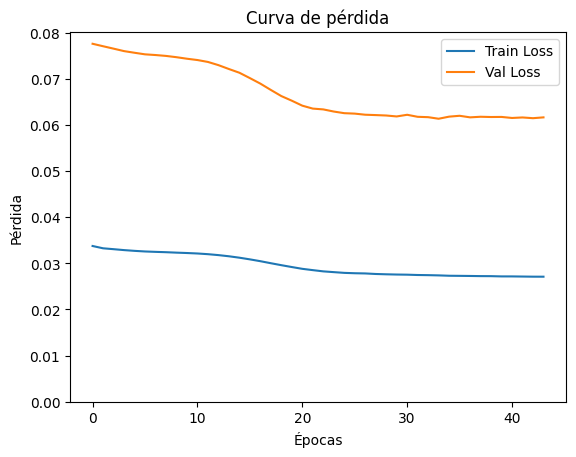

In [1267]:
# Grafica de las curvas de pérdida
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Curva de pérdida')
plt.ylim(0)
plt.show()

#### Testeo del modelo

In [1268]:
# Evaluación del modelo en el conjunto de test
model.eval()
model.load_state_dict(torch.load('./MejoresPesos/best_model_MLP_P4.pth'))  # Cargar los mejores pesos del modelo

test_loss = 0.0

preds = []
true = []
with torch.no_grad():
    for input, labels in zip(X_train, y_train):
        input, labels = input.to(device), labels.to(device)

        outputs = model(input)  
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds.append(outputs.cpu().numpy())
        true.append(labels.cpu().numpy())
    
test_loss /= len(X_test)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.0613


In [1269]:
# Metricas de evaluación
y_pred = np.concatenate(preds).reshape(-1, 1).ravel()
y_true = np.concatenate(true).reshape(-1, 1).ravel()

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 0.13
RMSE: 0.16
R²: 0.21


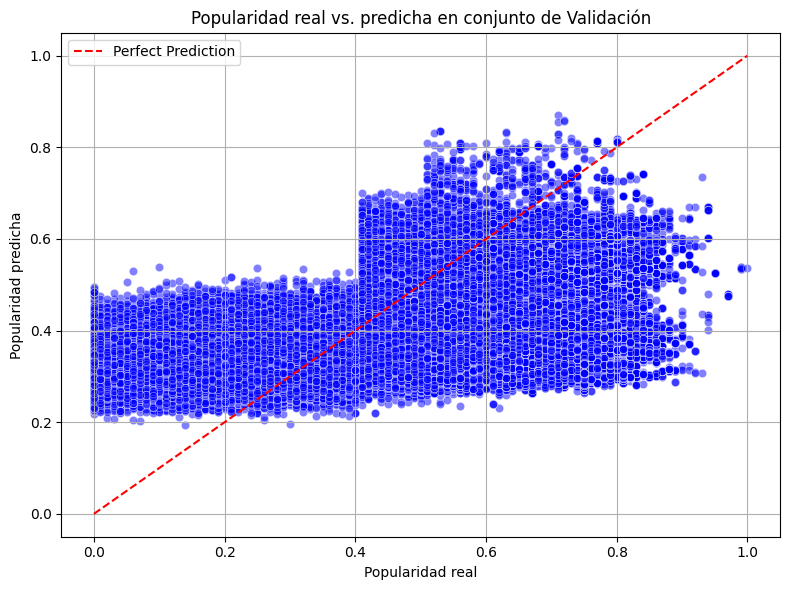

In [1270]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.5, color="blue")

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel("Popularidad real")
plt.ylabel("Popularidad predicha")
plt.title("Popularidad real vs. predicha en conjunto de Validación")
plt.legend()    
plt.grid(True)
plt.tight_layout()
plt.show()

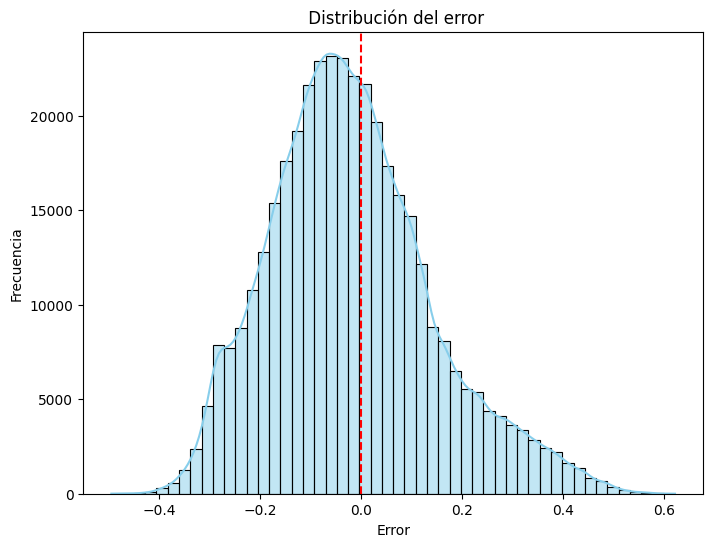

In [1271]:
residuos = y_true - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuos, bins=50, kde=True, color="skyblue")
plt.title(" Distribución del error")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.axvline(0, color='red', linestyle='--')
plt.show()